
В данной работе мы применим алгоритм для защиты модели. После отработки данного алгоритма мы увидим улучшение в работе модели, которая была подвергнута атаке.

Выполняем импорт необходимых библиотек.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets


Зададим нормализующие преобразования и загрузим набор данных (MNIST), разбить данные на подвыборки

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:",len(train_loader),"Validation data:",len(val_loader),"Test data: ",len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 61439365.22it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 27872916.20it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41238924.75it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 9225437.66it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data: 50000 Validation data: 10000 Test data:  10000


Настроим использование графического ускорителя.

In [3]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

Создадим класс НС на основе фреймворка torch.

In [4]:
class Net(nn.Module):
 def __init__(self):
  super(Net, self).__init__()
  self.conv1 = nn.Conv2d(1, 32, 3, 1)
  self.conv2 = nn.Conv2d(32, 64, 3, 1)
  self.dropout1 = nn.Dropout2d(0.25)
  self.dropout2 = nn.Dropout2d(0.5)
  self.fc1 = nn.Linear(9216, 128)
  self.fc2 = nn.Linear(128, 10)
 def forward(self, x):
  x = self.conv1(x)
  x = F.relu(x)
  x = self.conv2(x)
  x = F.relu(x)
  x = F.max_pool2d(x, 2)
  x = self.dropout1(x)
  x = torch.flatten(x, 1)
  x = self.fc1(x)
  x = F.relu(x)
  x = self.dropout2(x)
  x = self.fc2(x)
  output = F.log_softmax(x, dim=1)
  return output

Проверим работоспособность созданного класса НС.

In [5]:
model = Net().to(device)

Создадим оптимизатор, функцию потерь и трейнер сети.

In [6]:
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

Определим функцию обучения сети.

In [7]:
def fit(model,device,train_loader,val_loader,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
        else:
          val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

Обучим модель.

In [8]:
loss,val_loss=fit(model,device,train_loader,val_loader,10)

Fitting the model...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.2806496279286237 Val_Loss: 0.12787441771870753
Epoch: 2 Loss: 0.11299285361314047 Val_Loss: 0.10075318533363575
Epoch: 3 Loss: 0.0849774527908649 Val_Loss: 0.09567143414565794
Epoch: 4 Loss: 0.07608217686837153 Val_Loss: 0.08107877253171125
Epoch: 5 Loss: 0.0699291657627842 Val_Loss: 0.07728377175676672
Epoch: 6 Loss: 0.06695735126908428 Val_Loss: 0.0891313714174519
Epoch: 7 Loss: 0.06077906305478593 Val_Loss: 0.07742812868754662
Epoch: 8 Loss: 0.06131529724478225 Val_Loss: 0.09425340551983312
Epoch: 9 Loss: 0.05858486058967601 Val_Loss: 0.08656207511608456
Epoch: 10 Loss: 0.04640337399357746 Val_Loss: 0.06904277380505101


Построим графики потерь при обучении и валидации в зависимости от эпохи.

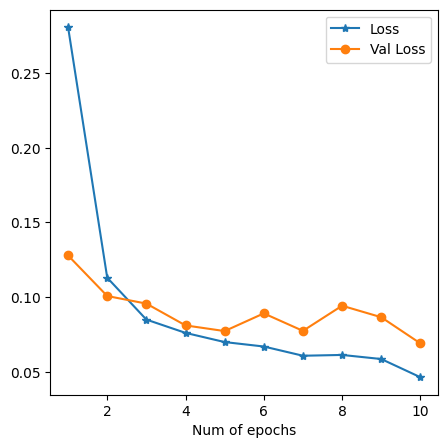

In [10]:
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-", label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

Создадим функции атак FGSM, I-FGSM, MI-FGSM.

In [11]:
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out


Создадим функцию проверки.

In [12]:
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

Построим графики успешности атак (Accuracy/эпсилон) и примеры выполненных атак в зависимости от степени возмущения epsilon.

Epsilon: 0	Test Accuracy = 9750 / 10000 = 0.975
Epsilon: 0.007	Test Accuracy = 9722 / 10000 = 0.9722
Epsilon: 0.01	Test Accuracy = 9723 / 10000 = 0.9723
Epsilon: 0.02	Test Accuracy = 9679 / 10000 = 0.9679
Epsilon: 0.03	Test Accuracy = 9613 / 10000 = 0.9613
Epsilon: 0.05	Test Accuracy = 9450 / 10000 = 0.945
Epsilon: 0.1	Test Accuracy = 8837 / 10000 = 0.8837
Epsilon: 0.2	Test Accuracy = 6246 / 10000 = 0.6246
Epsilon: 0.3	Test Accuracy = 3601 / 10000 = 0.3601


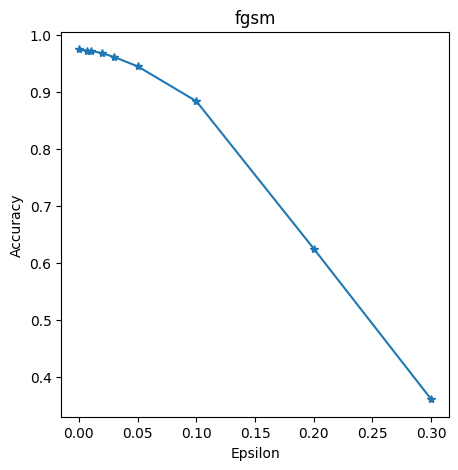

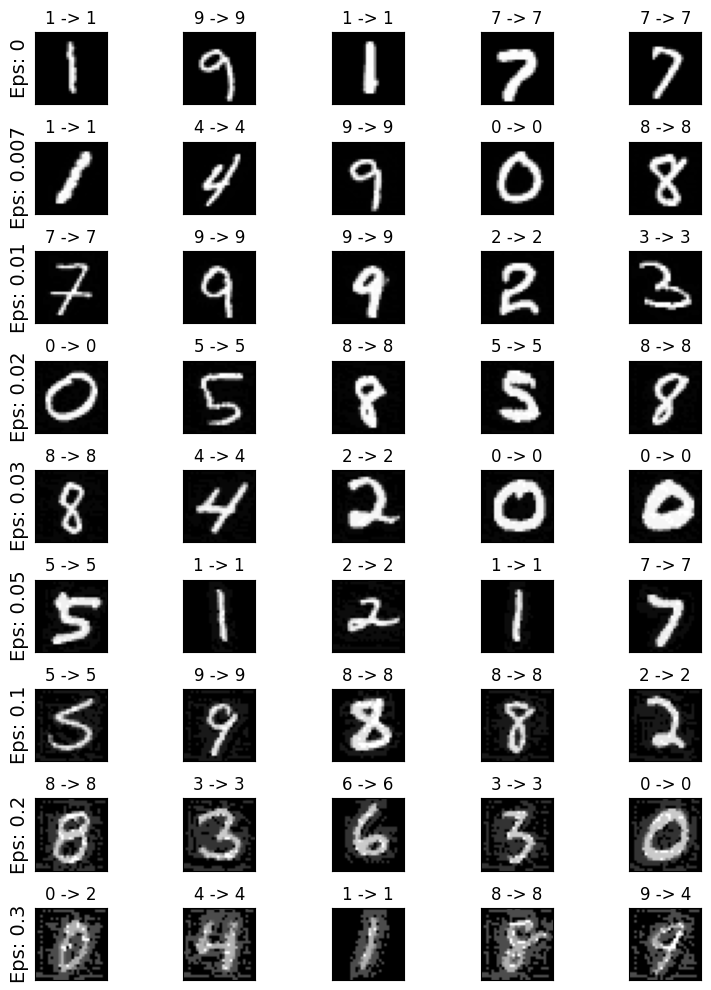

Epsilon: 0	Test Accuracy = 9751 / 10000 = 0.9751
Epsilon: 0.007	Test Accuracy = 9715 / 10000 = 0.9715
Epsilon: 0.01	Test Accuracy = 9709 / 10000 = 0.9709
Epsilon: 0.02	Test Accuracy = 9688 / 10000 = 0.9688
Epsilon: 0.03	Test Accuracy = 9612 / 10000 = 0.9612
Epsilon: 0.05	Test Accuracy = 9476 / 10000 = 0.9476
Epsilon: 0.1	Test Accuracy = 8841 / 10000 = 0.8841
Epsilon: 0.2	Test Accuracy = 6273 / 10000 = 0.6273
Epsilon: 0.3	Test Accuracy = 3484 / 10000 = 0.3484


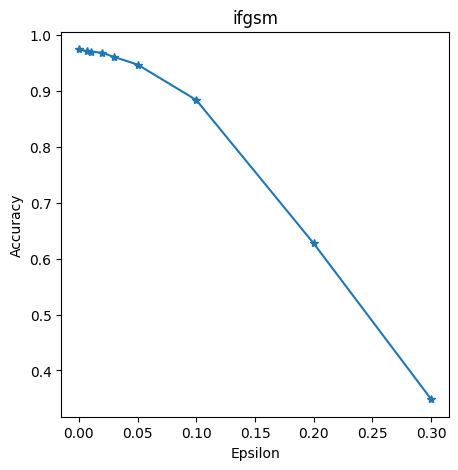

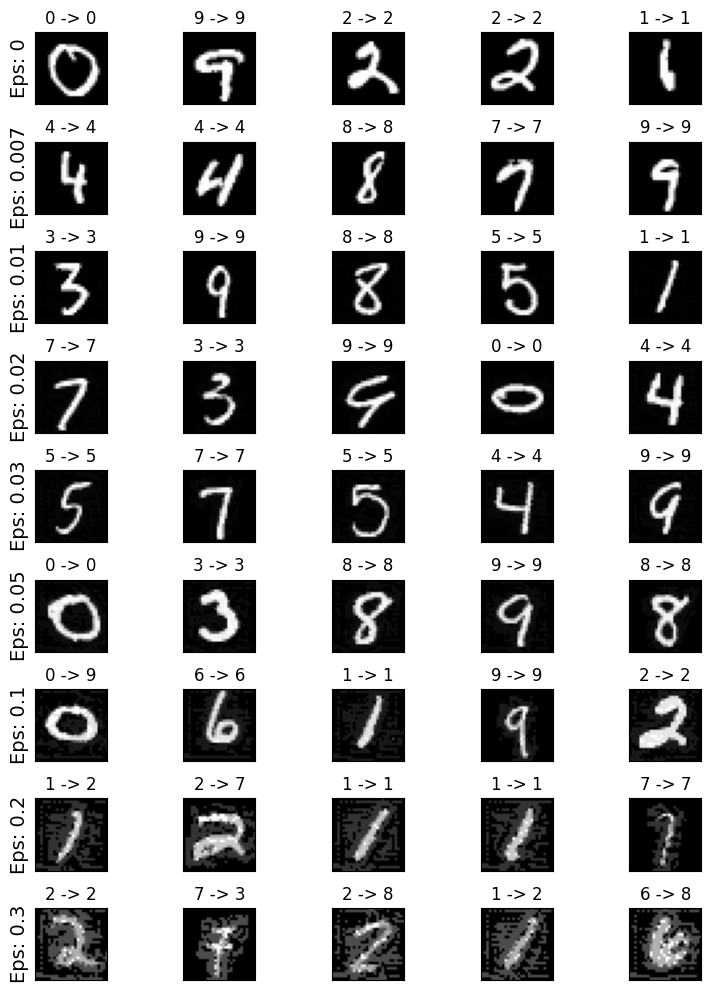

Epsilon: 0	Test Accuracy = 9738 / 10000 = 0.9738
Epsilon: 0.007	Test Accuracy = 9728 / 10000 = 0.9728
Epsilon: 0.01	Test Accuracy = 9713 / 10000 = 0.9713
Epsilon: 0.02	Test Accuracy = 9687 / 10000 = 0.9687
Epsilon: 0.03	Test Accuracy = 9634 / 10000 = 0.9634
Epsilon: 0.05	Test Accuracy = 9527 / 10000 = 0.9527
Epsilon: 0.1	Test Accuracy = 8986 / 10000 = 0.8986
Epsilon: 0.2	Test Accuracy = 6933 / 10000 = 0.6933
Epsilon: 0.3	Test Accuracy = 4250 / 10000 = 0.425


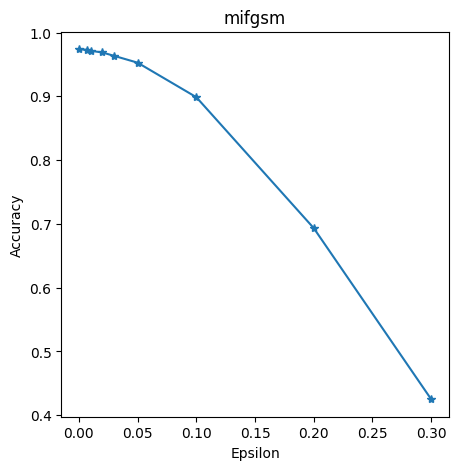

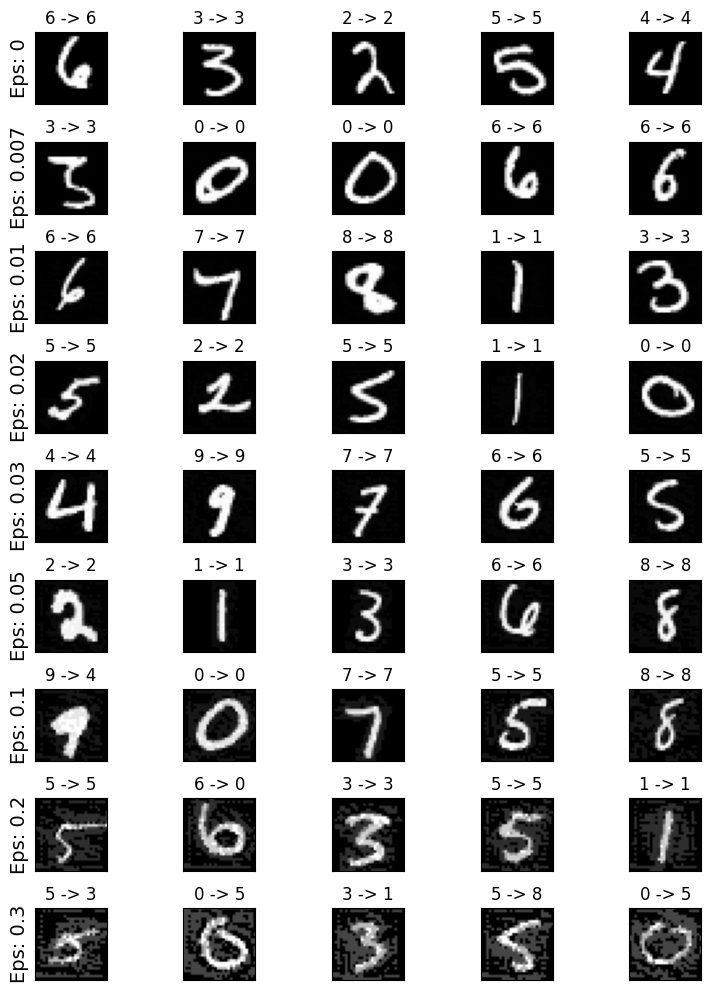

In [13]:
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()


Создадим 2 класса НС.

In [14]:
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

Переопределим функцию обучения и тестирования.

In [15]:
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss
  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

Создатдим функцию защиты методом дистилляции.

In [16]:
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):
  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)
  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)
  criterion = nn.NLLLoss()
  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  #converting target labels to soft labels
  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel
  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()
  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,"fgsm")
      accuracies.append(acc)
      examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()

  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

Получим результаты оценки защищенных сетей.

Fitting the model...
Epoch: 1 Loss: 0.5662047301409073 Val_Loss: 0.00018231202587485313
Epoch: 2 Loss: 0.3385203243374718 Val_Loss: 1.2374566635116935e-06
Epoch: 3 Loss: 0.25428086451666876 Val_Loss: 3.757412723643938e-07
Epoch: 4 Loss: 0.19064711203381343 Val_Loss: 0.00048478846549874106
Epoch: 5 Loss: 0.15228855001899314 Val_Loss: 1.921464577317238e-05
Epoch: 6 Loss: 0.1285232472288784 Val_Loss: 1.4979687286540866e-06
Epoch: 7 Loss: 0.11097932044940916 Val_Loss: 2.742809010669589e-08
Epoch: 8 Loss: 0.10269630508215549 Val_Loss: 7.760227151720756e-09
Epoch: 9 Loss: 0.09628898256426938 Val_Loss: 1.327698947279714e-05
Epoch: 10 Loss: 0.09052555274544327 Val_Loss: 1.2294865399599076e-05


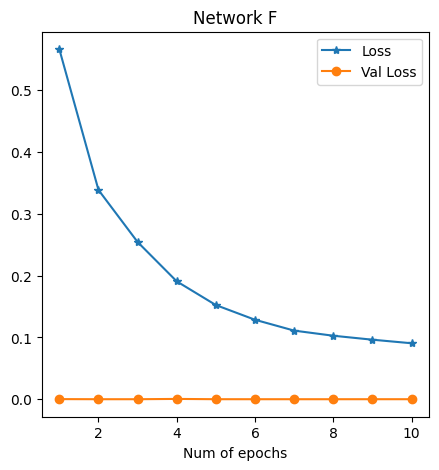

Fitting the model...
Epoch: 1 Loss: 0.6954153548508452 Val_Loss: 3.698446452617645e-05
Epoch: 2 Loss: 0.45832563545066807 Val_Loss: 1.771830189973116e-05
Epoch: 3 Loss: 0.3865080458324801 Val_Loss: 1.3489030115306378e-05
Epoch: 4 Loss: 0.3318358400624503 Val_Loss: 5.6694397889077666e-05
Epoch: 5 Loss: 0.2763107574661768 Val_Loss: 0.00014575666207820178
Epoch: 6 Loss: 0.2445015275636196 Val_Loss: 4.863006553932791e-07
Epoch: 7 Loss: 0.22031390263005912 Val_Loss: 1.8023547500524728e-05
Epoch: 8 Loss: 0.20348487243809338 Val_Loss: 3.601938886276912e-07
Epoch: 9 Loss: 0.19343684324045543 Val_Loss: 5.017868280410767e-05
Epoch: 10 Loss: 0.1826015582433685 Val_Loss: 0.00013195873200893402


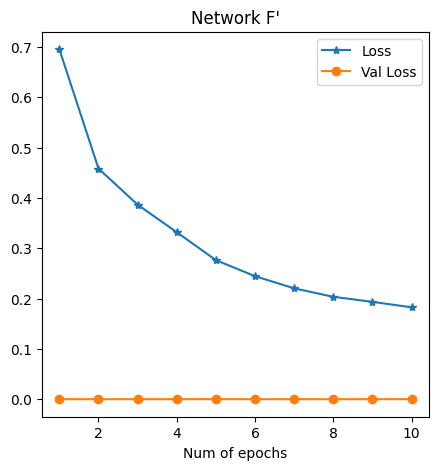

Epsilon: 0	Test Accuracy = 9263 / 10000 = 0.9263
Epsilon: 0.007	Test Accuracy = 9170 / 10000 = 0.917
Epsilon: 0.01	Test Accuracy = 9107 / 10000 = 0.9107
Epsilon: 0.02	Test Accuracy = 9016 / 10000 = 0.9016
Epsilon: 0.03	Test Accuracy = 8894 / 10000 = 0.8894
Epsilon: 0.05	Test Accuracy = 8496 / 10000 = 0.8496
Epsilon: 0.1	Test Accuracy = 7037 / 10000 = 0.7037
Epsilon: 0.2	Test Accuracy = 2894 / 10000 = 0.2894
Epsilon: 0.3	Test Accuracy = 1105 / 10000 = 0.1105
Epsilon: 0	Test Accuracy = 9214 / 10000 = 0.9214
Epsilon: 0.007	Test Accuracy = 9185 / 10000 = 0.9185
Epsilon: 0.01	Test Accuracy = 9117 / 10000 = 0.9117
Epsilon: 0.02	Test Accuracy = 9012 / 10000 = 0.9012
Epsilon: 0.03	Test Accuracy = 8906 / 10000 = 0.8906
Epsilon: 0.05	Test Accuracy = 8507 / 10000 = 0.8507
Epsilon: 0.1	Test Accuracy = 6995 / 10000 = 0.6995
Epsilon: 0.2	Test Accuracy = 2945 / 10000 = 0.2945
Epsilon: 0.3	Test Accuracy = 1156 / 10000 = 0.1156
Epsilon: 0	Test Accuracy = 9203 / 10000 = 0.9203
Epsilon: 0.007	Test Accura

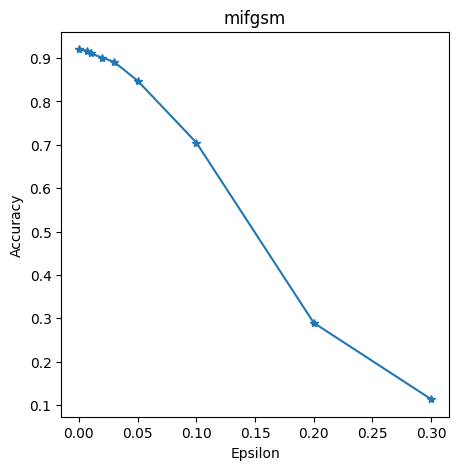

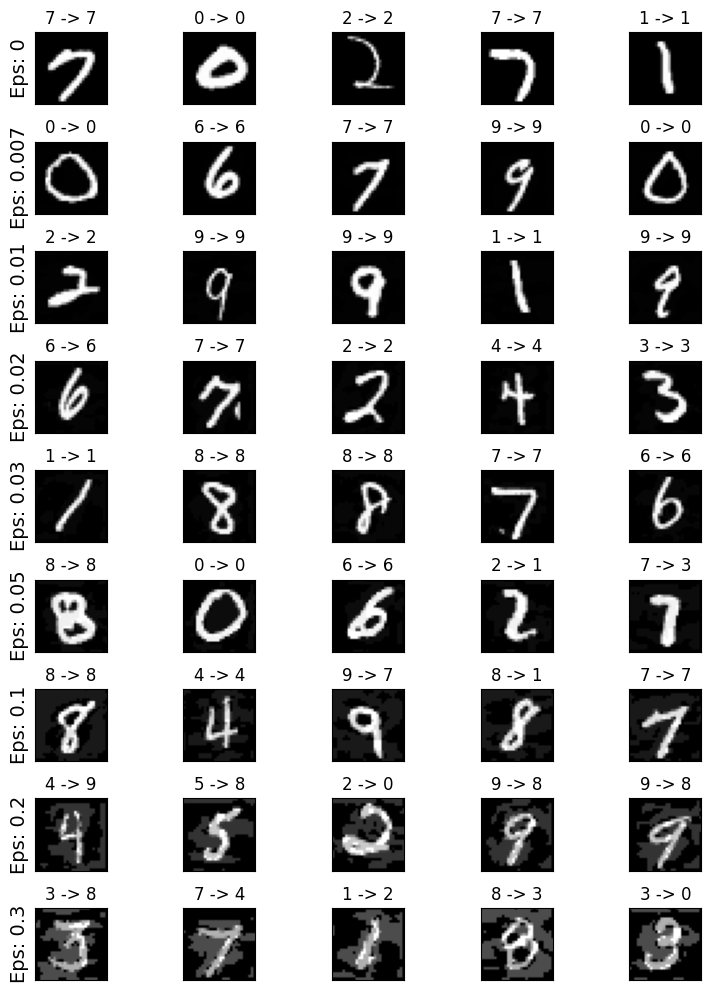

In [17]:
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)